In [ ]:
# Composer Classification using LSTM and CNN
# Predicting composers: Bach, Beethoven, Chopin, Mozart from MIDI files


# Install required packages first
import subprocess
import sys

# Install packages if needed
packages = ['pretty_midi', 'librosa', 'music21']

for package in packages:
    try:
        __import__(package.replace('-', '_'))
        print(f"{package} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
        except:
            print(f"Failed to install {package}, continuing...")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import zipfile
import glob
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Try to import music processing libraries
try:
    import music21
    MUSIC21_AVAILABLE = True
except ImportError:
    MUSIC21_AVAILABLE = False
    print("Warning: music21 not available.")

try:
    import pretty_midi
    PRETTY_MIDI_AVAILABLE = True
except ImportError:
    PRETTY_MIDI_AVAILABLE = False
    print("Warning: pretty_midi not available.")

try:
    import librosa
    LIBROSA_AVAILABLE = True
except ImportError:
    LIBROSA_AVAILABLE = False
    print("Warning: librosa not available.")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration parameters
dataset_path = '/content/midiclassics.zip'
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']
label_encoder = LabelEncoder()
sequence_length = 100
features_per_note = 4  # pitch, velocity, duration, time_offset

print("Starting Composer Classification Pipeline...")
print("=" * 50)

# Extract the dataset if it's in zip format
if dataset_path.endswith('.zip'):
    extract_path = os.path.dirname(dataset_path)
    try:
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Dataset extracted successfully!")
        extract_path = os.path.join(extract_path, 'midiclassics')
    except:
        print("Failed to extract dataset")
        extract_path = dataset_path
else:
    extract_path = dataset_path

# Load MIDI files and organize by composer
midi_files = []
labels = []

for composer in composers:
    # Multiple search patterns to find composer files
    search_patterns = [
        os.path.join(extract_path, f"**/*{composer.lower()}*", "*.mid*"),
        os.path.join(extract_path, f"*{composer.lower()}*", "*.mid*"),
        os.path.join(extract_path, "**", f"*{composer.lower()}*.mid*"),
        os.path.join(extract_path, f"**/*{composer}*", "*.mid*"),
        os.path.join(extract_path, f"*{composer}*", "*.mid*"),
        os.path.join(extract_path, "**", f"*{composer}*.mid*")
    ]

    composer_files = []
    for pattern in search_patterns:
        files = glob.glob(pattern, recursive=True)
        composer_files.extend(files)

    # Remove duplicates
    composer_files = list(set(composer_files))

    print(f"Found {len(composer_files)} files for {composer}")

    for file_path in composer_files:
        midi_files.append(file_path)
        labels.append(composer)

print(f"Total files loaded: {len(midi_files)}")
if labels:
    print("Distribution:", Counter(labels))

if not midi_files:
    print("No MIDI files found! Please check your dataset path.")
    exit()

# Feature extraction from MIDI files
print("Extracting features...")
features_list = []
valid_labels = []

for midi_file, label in zip(midi_files, labels):
    try:
        features = None

        # Try pretty_midi first
        if PRETTY_MIDI_AVAILABLE and features is None:
            try:
                # Load MIDI file
                midi_data = pretty_midi.PrettyMIDI(midi_file)

                # Extract notes from all instruments
                notes = []
                for instrument in midi_data.instruments:
                    if not instrument.is_drum:
                        for note in instrument.notes:
                            notes.append({
                                'pitch': note.pitch,
                                'velocity': note.velocity,
                                'start': note.start,
                                'end': note.end,
                                'duration': note.end - note.start
                            })

                if notes:
                    # Sort notes by start time
                    notes = sorted(notes, key=lambda x: x['start'])

                    # Convert to feature vectors
                    feature_vectors = []
                    prev_start = 0

                    for note in notes:
                        time_offset = note['start'] - prev_start
                        feature_vector = [
                            note['pitch'] / 127.0,  # Normalized pitch
                            note['velocity'] / 127.0,  # Normalized velocity
                            min(note['duration'], 4.0) / 4.0,  # Normalized duration
                            min(time_offset, 4.0) / 4.0  # Normalized time offset
                        ]
                        feature_vectors.append(feature_vector)
                        prev_start = note['start']

                    features = np.array(feature_vectors)
            except:
                pass

        # Try music21 if pretty_midi failed
        if MUSIC21_AVAILABLE and features is None:
            try:
                # Load MIDI file
                score = music21.converter.parse(midi_file)

                # Extract notes
                notes = []
                for element in score.flatten().notes:
                    if hasattr(element, 'pitch'):  # Single note
                        notes.append({
                            'pitch': element.pitch.midi,
                            'duration': float(element.quarterLength),
                            'offset': float(element.offset)
                        })
                    elif hasattr(element, 'pitches'):  # Chord
                        for pitch in element.pitches:
                            notes.append({
                                'pitch': pitch.midi,
                                'duration': float(element.quarterLength),
                                'offset': float(element.offset)
                            })

                if notes:
                    # Sort notes by offset
                    notes = sorted(notes, key=lambda x: x['offset'])

                    # Convert to feature vectors
                    feature_vectors = []
                    prev_offset = 0

                    for note in notes:
                        time_offset = note['offset'] - prev_offset
                        feature_vector = [
                            note['pitch'] / 127.0,  # Normalized pitch
                            0.8,  # Default velocity
                            min(note['duration'], 4.0) / 4.0,  # Normalized duration
                            min(time_offset, 4.0) / 4.0  # Normalized time offset
                        ]
                        feature_vectors.append(feature_vector)
                        prev_offset = note['offset']

                    features = np.array(feature_vectors)
            except:
                pass

        # Fallback to basic extraction
        if features is None:
            try:
                with open(midi_file, 'rb') as f:
                    data = f.read()

                # Generate pseudo-features based on file content
                byte_values = list(data[:1000])  # First 1000 bytes
                if len(byte_values) >= sequence_length * features_per_note:
                    feature_vectors = []

                    # Convert bytes to normalized features
                    for i in range(0, len(byte_values) - 3, 4):
                        if len(feature_vectors) >= sequence_length:
                            break
                        feature_vector = [
                            byte_values[i] / 255.0,      # Normalized byte value 1
                            byte_values[i+1] / 255.0,    # Normalized byte value 2
                            byte_values[i+2] / 255.0,    # Normalized byte value 3
                            byte_values[i+3] / 255.0     # Normalized byte value 4
                        ]
                        feature_vectors.append(feature_vector)

                    features = np.array(feature_vectors)
            except:
                pass

        if features is not None and len(features) >= sequence_length:
            features_list.append(features)
            valid_labels.append(label)

    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        continue

print(f"Successfully processed {len(features_list)} files")

if not features_list:
    print("No valid features extracted!")
    exit()

# Create sequences for training
print("Creating sequences...")
X, y = [], []

for features, label in zip(features_list, valid_labels):
    if features is None or len(features) < sequence_length:
        continue

    # Create overlapping sequences
    for i in range(0, len(features) - sequence_length + 1, sequence_length // 2):
        sequence = features[i:i + sequence_length]
        if len(sequence) == sequence_length:
            X.append(sequence)
            y.append(label)

X = np.array(X)
y = np.array(y)

if len(X) == 0:
    print("No sequences created!")
    exit()

# Encode labels
y_encoded = label_encoder.fit_transform(y)

print(f"Created {len(X)} sequences")
print(f"Sequence shape: {X.shape}")
print("Label distribution:", Counter(y))

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

input_shape = (sequence_length, features_per_note)
num_classes = len(composers)


Installing pretty_midi...
librosa is already installed
music21 is already installed
Starting Composer Classification Pipeline...
Dataset extracted successfully!
Found 139 files for Bach
Found 133 files for Beethoven
Found 136 files for Chopin
Found 90 files for Mozart
Total files loaded: 498
Distribution: Counter({'Bach': 139, 'Chopin': 136, 'Beethoven': 133, 'Mozart': 90})
Extracting features...
Successfully processed 497 files
Creating sequences...
Created 33179 sequences
Sequence shape: (33179, 100, 4)
Label distribution: Counter({np.str_('Beethoven'): 13328, np.str_('Mozart'): 6861, np.str_('Bach'): 6798, np.str_('Chopin'): 6192})
Training set: 19907 samples
Validation set: 6636 samples
Test set: 6636 samples


Class Weights: {0: np.float64(1.2203898970083373), 1: np.float64(0.6224049524762382), 2: np.float64(1.3392761033369214), 3: np.float64(1.2088292445955793)}
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 217s 672ms/step - accuracy: 0.3278 - loss: 1.2994 - val_accuracy: 0.3630 - val_loss: 1.2496 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 208s 668ms/step - accuracy: 0.4513 - loss: 1.1807 - val_accuracy: 0.5154 - val_loss: 1.1023 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 669ms/step - accuracy: 0.4941 - loss: 1.0957 - val_accuracy: 0.5012 - val_loss: 1.1077 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 211s 675ms/step - accuracy: 0.5039 - loss: 1.0907 - val_accuracy: 0.5315 - val_loss: 1.0539 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 209s 671ms/step - accuracy: 0.5141 - loss: 1.0612 - val_accuracy: 0.5472 - val_loss: 1.0195 - learning_rate: 0.0010
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 208s 668ms/step - accura

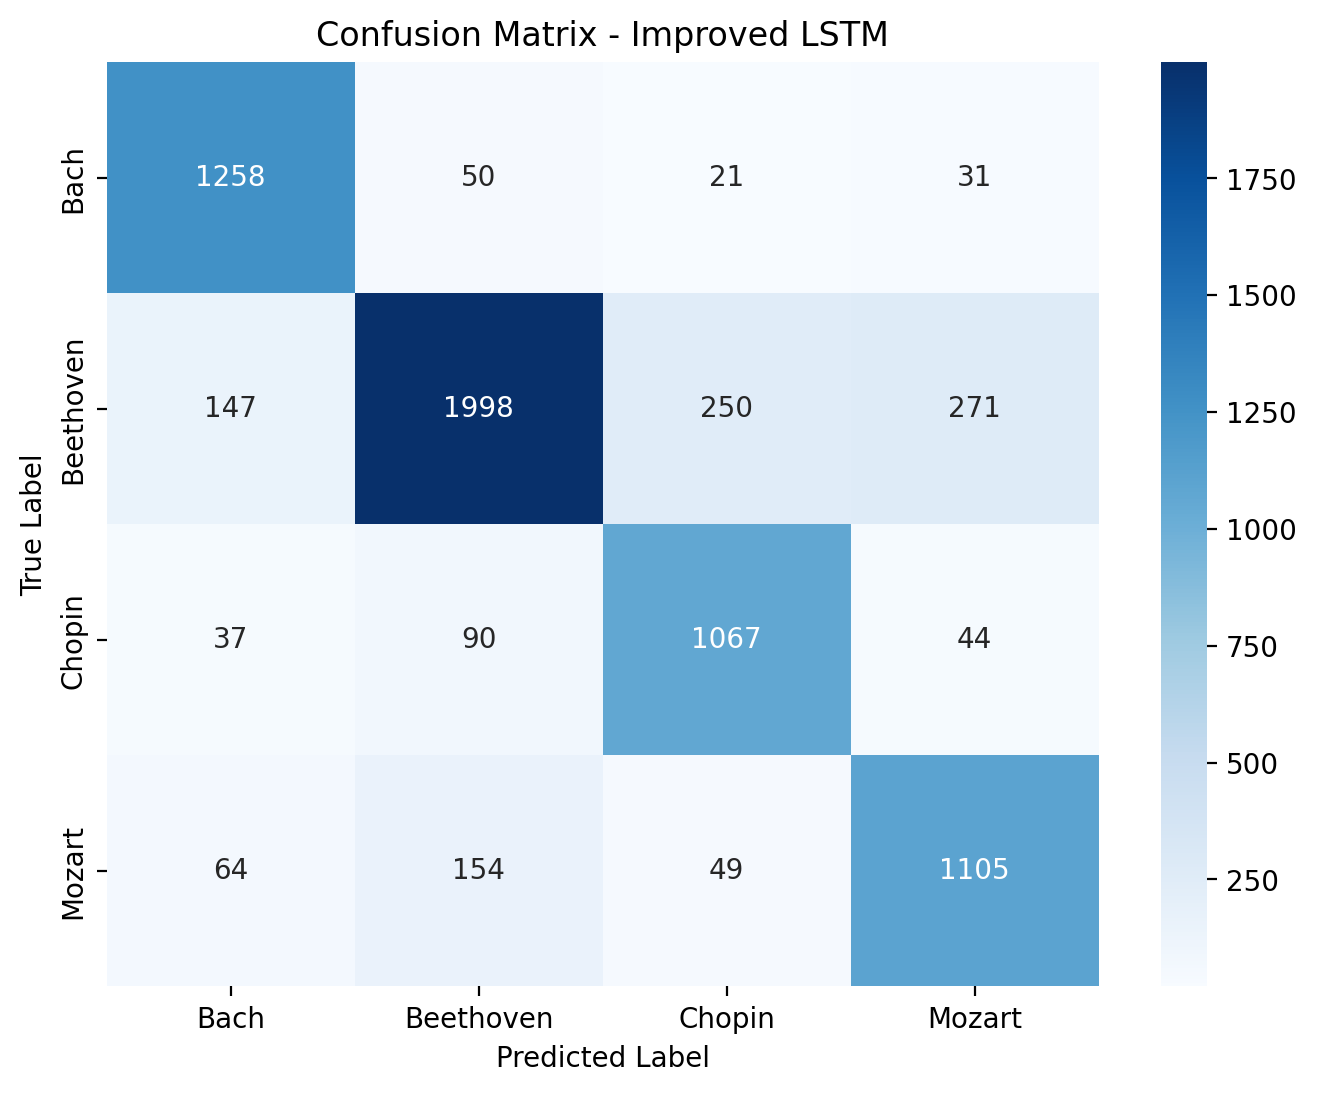

              precision    recall  f1-score   support

        Bach       0.84      0.93      0.88      1360
   Beethoven       0.87      0.75      0.81      2666
      Chopin       0.77      0.86      0.81      1238
      Mozart       0.76      0.81      0.78      1372

    accuracy                           0.82      6636
   macro avg       0.81      0.84      0.82      6636
weighted avg       0.82      0.82      0.82      6636



In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ---------- 1. Handle Class Imbalance ----------
# If y_train is one-hot encoded, convert it to integer labels
if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train  # already integer labels

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ---------- 2. Build LSTM Model ----------
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_labels)), activation='softmax')
])

# ---------- 3. Compile Model ----------
model.compile(
    loss='sparse_categorical_crossentropy' if len(y_train.shape) == 1 or y_train.shape[1] == 1 else 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# ---------- 4. Callbacks ----------
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# ---------- 5. Train Model with Class Weights ----------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------- 6. Evaluate ----------
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

# ---------- 7. Predict & Confusion Matrix ----------
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = y_test if len(y_test.shape) == 1 or y_test.shape[1] == 1 else np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Improved LSTM')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))


Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.3685 - loss: 1.2520 - val_accuracy: 0.5068 - val_loss: 1.0908 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5254 - loss: 1.0332 - val_accuracy: 0.5785 - val_loss: 0.9963 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.5863 - loss: 0.9509 - val_accuracy: 0.6181 - val_loss: 0.9279 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.6171 - loss: 0.8908 - val_accuracy: 0.6219 - val_loss: 0.9109 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6342 - loss: 0.8397 - val_accuracy: 0.6279 - val_loss: 0.8973 - learning_rate: 0.0010
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.6562 - loss: 0.8063 - val_accuracy: 0.5946 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.6679 - l

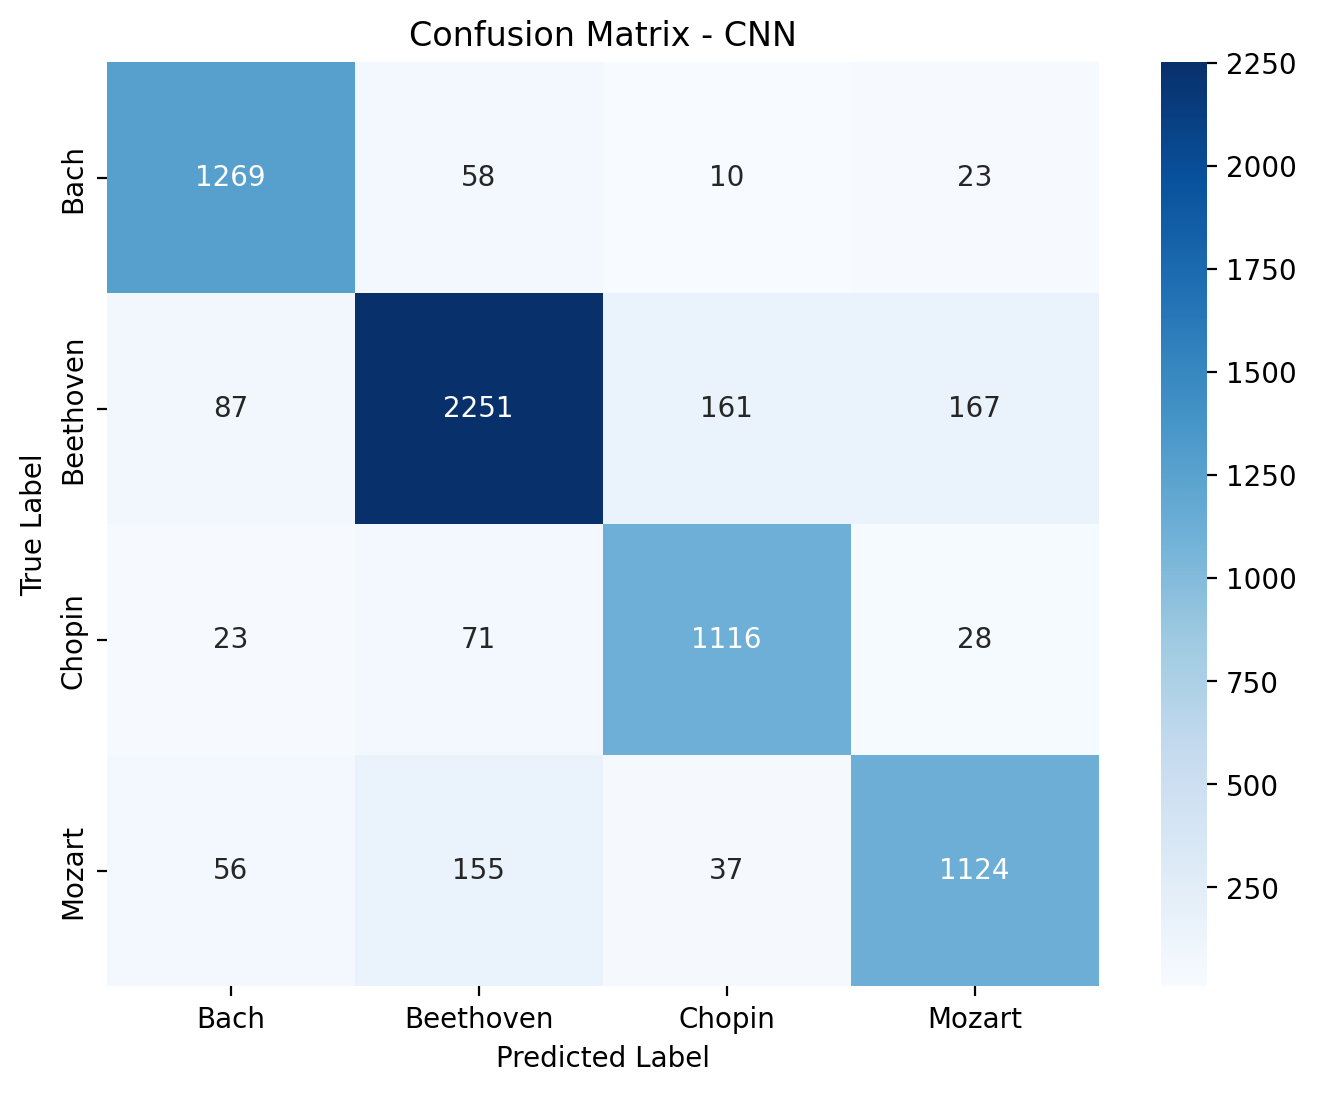

              precision    recall  f1-score   support

        Bach       0.88      0.93      0.91      1360
   Beethoven       0.89      0.84      0.87      2666
      Chopin       0.84      0.90      0.87      1238
      Mozart       0.84      0.82      0.83      1372

    accuracy                           0.87      6636
   macro avg       0.86      0.87      0.87      6636
weighted avg       0.87      0.87      0.87      6636



In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# ---------- 1. Build CNN Model ----------
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_labels)), activation='softmax')
])

# ---------- 2. Compile CNN ----------
cnn_model.compile(
    loss='sparse_categorical_crossentropy' if len(y_train.shape) == 1 or y_train.shape[1] == 1 else 'categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# ---------- 3. Train CNN with Class Weights ----------
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ---------- 4. Evaluate CNN ----------
cnn_loss, cnn_acc = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (CNN): {cnn_acc:.4f}")

# ---------- 5. Predict & Confusion Matrix for CNN ----------
cnn_y_pred = np.argmax(cnn_model.predict(X_test), axis=1)
cnn_y_true = y_test if len(y_test.shape) == 1 or y_test.shape[1] == 1 else np.argmax(y_test, axis=1)

cnn_cm = confusion_matrix(cnn_y_true, cnn_y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cnn_cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN')
plt.show()

print(classification_report(cnn_y_true, cnn_y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))



Building CNN Model...
CNN Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 98, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 49, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 47, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 21, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,740 (549.77 KB)

 Trainable params: 140,740 (549.77 KB)

 Non-trainable params: 0 (0.00 B)

Training CNN Model...
Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.3384 - loss: 1.2853 - val_accuracy: 0.4681 - val_loss: 1.1389 - learning_rate: 0.0010
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.5093 - loss: 1.0643 - val_accuracy: 0.5823 - val_loss: 0.9751 - learning_rate: 0.0010
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5782 - loss: 0.9606 - val_accuracy: 0.5743 - val_loss: 0.9694 - learning_rate: 0.0010
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.6191 - loss: 0.8804 - val_accuracy: 0.6007 - val_loss: 0.9138 - learning_rate: 0.0010
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6444 - loss: 0.8211 - val_accuracy: 0.6730 - val_loss: 0.7895 - learning_rate: 0.0010
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6914 - loss: 0.7468 - val_accuracy: 0.6844 - val_loss: 0.7615 - learning_rate: 0.0010
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step 

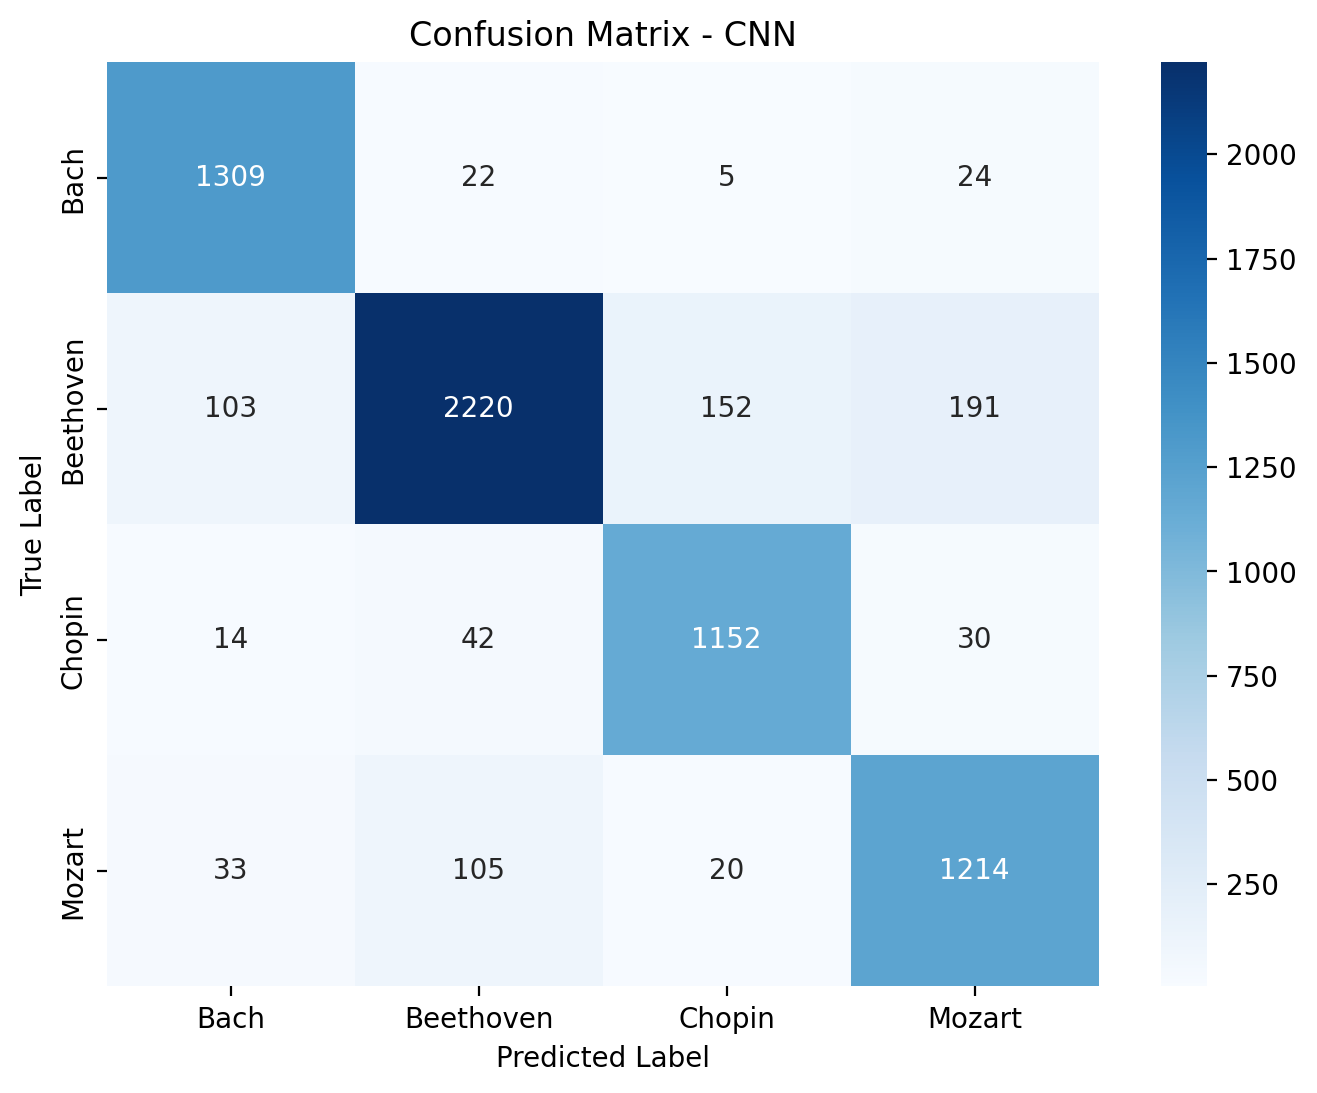

              precision    recall  f1-score   support

        Bach       0.90      0.96      0.93      1360
   Beethoven       0.93      0.83      0.88      2666
      Chopin       0.87      0.93      0.90      1238
      Mozart       0.83      0.88      0.86      1372

    accuracy                           0.89      6636
   macro avg       0.88      0.90      0.89      6636
weighted avg       0.89      0.89      0.89      6636



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# ==============================
# Build CNN model
# ==============================
print("\n" + "="*30)
print("Building CNN Model...")
print("="*30)

cnn_model1 = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

cnn_model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # Works with integer labels
    metrics=['accuracy']
)

print("CNN Model Summary:")
cnn_model1.summary()

# ==============================
# Define callbacks
# ==============================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [early_stop, reduce_lr]

# ==============================
# Train CNN model with class weights
# ==============================
print("Training CNN Model...")
cnn_history1 = cnn_model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    class_weight=class_weights_dict,  # From earlier LSTM section
    callbacks=callbacks,
    verbose=1
)

# ==============================
# Evaluate CNN model
# ==============================
cnn_loss1, cnn_acc1 = cnn_model1.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy (CNN): {cnn_acc1:.4f}")

# ==============================
# Predict & Confusion Matrix
# ==============================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = np.argmax(cnn_model1.predict(X_test), axis=1)
y_true = y_test if len(y_test.shape) == 1 else np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'],
            yticklabels=['Bach', 'Beethoven', 'Chopin', 'Mozart'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - CNN')
plt.show()

print(classification_report(y_true, y_pred, target_names=['Bach', 'Beethoven', 'Chopin', 'Mozart']))



Building Hybrid LSTM-CNN Model...
Hybrid Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 98, 64)    │        832 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 49, 64)    │          0 │ conv1d_2[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 49, 64)    │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 100, 64)   │     17,664 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 47, 32)    │      6,176 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 100, 64)   │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 23, 32)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 23, 32)    │          0 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 736)       │          0 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 768)       │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     98,432 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ dense_3[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_4[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 4)         │        260 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 144,036 (562.64 KB)

 Trainable params: 144,036 (562.64 KB)

 Non-trainable params: 0 (0.00 B)

Training Hybrid Model...
Epoch 1/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.4360 - loss: 1.2389

623/623 ━━━━━━━━━━━━━━━━━━━━ 79s 119ms/step - accuracy: 0.4361 - loss: 1.2388 - val_accuracy: 0.5012 - val_loss: 1.1093
Epoch 2/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.5569 - loss: 1.0364

623/623 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.5569 - loss: 1.0364 - val_accuracy: 0.6248 - val_loss: 0.9253
Epoch 3/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6119 - loss: 0.9524

623/623 ━━━━━━━━━━━━━━━━━━━━ 78s 105ms/step - accuracy: 0.6119 - loss: 0.9524 - val_accuracy: 0.6307 - val_loss: 0.8969
Epoch 4/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6408 - loss: 0.8964

623/623 ━━━━━━━━━━━━━━━━━━━━ 72s 115ms/step - accuracy: 0.6408 - loss: 0.8964 - val_accuracy: 0.6646 - val_loss: 0.8255
Epoch 5/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6599 - loss: 0.8550

623/623 ━━━━━━━━━━━━━━━━━━━━ 76s 105ms/step - accuracy: 0.6599 - loss: 0.8549 - val_accuracy: 0.6793 - val_loss: 0.7867
Epoch 6/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.6773 - loss: 0.8083

623/623 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.6773 - loss: 0.8083 - val_accuracy: 0.6962 - val_loss: 0.7618
Epoch 7/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6934 - loss: 0.7783

623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.6934 - loss: 0.7783 - val_accuracy: 0.7289 - val_loss: 0.7025
Epoch 8/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - accuracy: 0.7137 - loss: 0.7400 - val_accuracy: 0.7143 - val_loss: 0.7281
Epoch 9/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7195 - loss: 0.7119

623/623 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7195 - loss: 0.7119 - val_accuracy: 0.7413 - val_loss: 0.6727
Epoch 10/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7352 - loss: 0.6811

623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - accuracy: 0.7352 - loss: 0.6810 - val_accuracy: 0.7547 - val_loss: 0.6526
Epoch 11/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7480 - loss: 0.6688

623/623 ━━━━━━━━━━━━━━━━━━━━ 80s 106ms/step - accuracy: 0.7480 - loss: 0.6688 - val_accuracy: 0.7568 - val_loss: 0.6382
Epoch 12/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7580 - loss: 0.6353

623/623 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.7580 - loss: 0.6352 - val_accuracy: 0.7670 - val_loss: 0.6043
Epoch 13/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7610 - loss: 0.6235

623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.7610 - loss: 0.6235 - val_accuracy: 0.7815 - val_loss: 0.5820
Epoch 14/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.7695 - loss: 0.6138

623/623 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.7695 - loss: 0.6138 - val_accuracy: 0.7833 - val_loss: 0.5685
Epoch 15/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7798 - loss: 0.5876

623/623 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7798 - loss: 0.5876 - val_accuracy: 0.7878 - val_loss: 0.5643
Epoch 16/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7820 - loss: 0.5739

623/623 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.7820 - loss: 0.5739 - val_accuracy: 0.7928 - val_loss: 0.5499
Epoch 17/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 78s 106ms/step - accuracy: 0.7904 - loss: 0.5595 - val_accuracy: 0.7889 - val_loss: 0.5529
Epoch 18/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 115ms/step - accuracy: 0.7936 - loss: 0.5543 - val_accuracy: 0.7875 - val_loss: 0.5545
Epoch 19/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 76s 106ms/step - accuracy: 0.7992 - loss: 0.5381 - val_accuracy: 0.7877 - val_loss: 0.5507
Epoch 20/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.7952 - loss: 0.5363 - val_accuracy: 0.7829 - val_loss: 0.5665
Epoch 21/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8018 - loss: 0.5253

623/623 ━━━━━━━━━━━━━━━━━━━━ 87s 114ms/step - accuracy: 0.8019 - loss: 0.5253 - val_accuracy: 0.8029 - val_loss: 0.5153
Epoch 22/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8048 - loss: 0.5142

623/623 ━━━━━━━━━━━━━━━━━━━━ 77s 105ms/step - accuracy: 0.8048 - loss: 0.5142 - val_accuracy: 0.8137 - val_loss: 0.4992
Epoch 23/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 87s 114ms/step - accuracy: 0.8111 - loss: 0.5080 - val_accuracy: 0.8049 - val_loss: 0.5154
Epoch 24/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.8172 - loss: 0.4934 - val_accuracy: 0.8006 - val_loss: 0.5202
Epoch 25/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8148 - loss: 0.4957

623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8148 - loss: 0.4957 - val_accuracy: 0.8127 - val_loss: 0.4957
Epoch 26/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8179 - loss: 0.4859

623/623 ━━━━━━━━━━━━━━━━━━━━ 88s 114ms/step - accuracy: 0.8179 - loss: 0.4859 - val_accuracy: 0.8130 - val_loss: 0.4837
Epoch 27/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - accuracy: 0.8225 - loss: 0.4805 - val_accuracy: 0.8068 - val_loss: 0.5116
Epoch 28/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8208 - loss: 0.4732

623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8208 - loss: 0.4732 - val_accuracy: 0.8202 - val_loss: 0.4732
Epoch 29/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.8276 - loss: 0.4613 - val_accuracy: 0.8171 - val_loss: 0.4877
Epoch 30/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8303 - loss: 0.4560

623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8303 - loss: 0.4560 - val_accuracy: 0.8291 - val_loss: 0.4662
Epoch 31/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 104ms/step - accuracy: 0.8363 - loss: 0.4457 - val_accuracy: 0.8210 - val_loss: 0.4754
Epoch 32/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.8355 - loss: 0.4522 - val_accuracy: 0.8216 - val_loss: 0.4783
Epoch 33/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 80s 104ms/step - accuracy: 0.8319 - loss: 0.4425 - val_accuracy: 0.8146 - val_loss: 0.5035
Epoch 34/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - accuracy: 0.8346 - loss: 0.4382 - val_accuracy: 0.8241 - val_loss: 0.4835
Epoch 35/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8356 - loss: 0.4331

623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8356 - loss: 0.4331 - val_accuracy: 0.8290 - val_loss: 0.4616
Epoch 36/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.8417 - loss: 0.4296

623/623 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.8417 - loss: 0.4295 - val_accuracy: 0.8202 - val_loss: 0.4565
Epoch 37/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 71s 114ms/step - accuracy: 0.8354 - loss: 0.4277 - val_accuracy: 0.8205 - val_loss: 0.4796
Epoch 38/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 112ms/step - accuracy: 0.8403 - loss: 0.4255 - val_accuracy: 0.8263 - val_loss: 0.4580
Epoch 39/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 83s 113ms/step - accuracy: 0.8495 - loss: 0.4090 - val_accuracy: 0.8186 - val_loss: 0.4814
Epoch 40/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.8414 - loss: 0.4186 - val_accuracy: 0.8213 - val_loss: 0.4798
Epoch 41/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8540 - loss: 0.3981

623/623 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.8540 - loss: 0.3981 - val_accuracy: 0.8327 - val_loss: 0.4490
Epoch 42/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.8453 - loss: 0.4134

623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8453 - loss: 0.4133 - val_accuracy: 0.8421 - val_loss: 0.4221
Epoch 43/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 108ms/step - accuracy: 0.8537 - loss: 0.3943 - val_accuracy: 0.8326 - val_loss: 0.4411
Epoch 44/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - accuracy: 0.8523 - loss: 0.3993 - val_accuracy: 0.8409 - val_loss: 0.4237
Epoch 45/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 67s 107ms/step - accuracy: 0.8506 - loss: 0.3972 - val_accuracy: 0.8410 - val_loss: 0.4261
Epoch 46/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 85s 112ms/step - accuracy: 0.8530 - loss: 0.3927 - val_accuracy: 0.8324 - val_loss: 0.4525
Epoch 47/50
623/623 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.8567 - loss: 0.3850 - val_accuracy: 0.8299 - val_loss: 0.4601

Evaluating Hybrid Model...
Test Accuracy: 0.8362
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


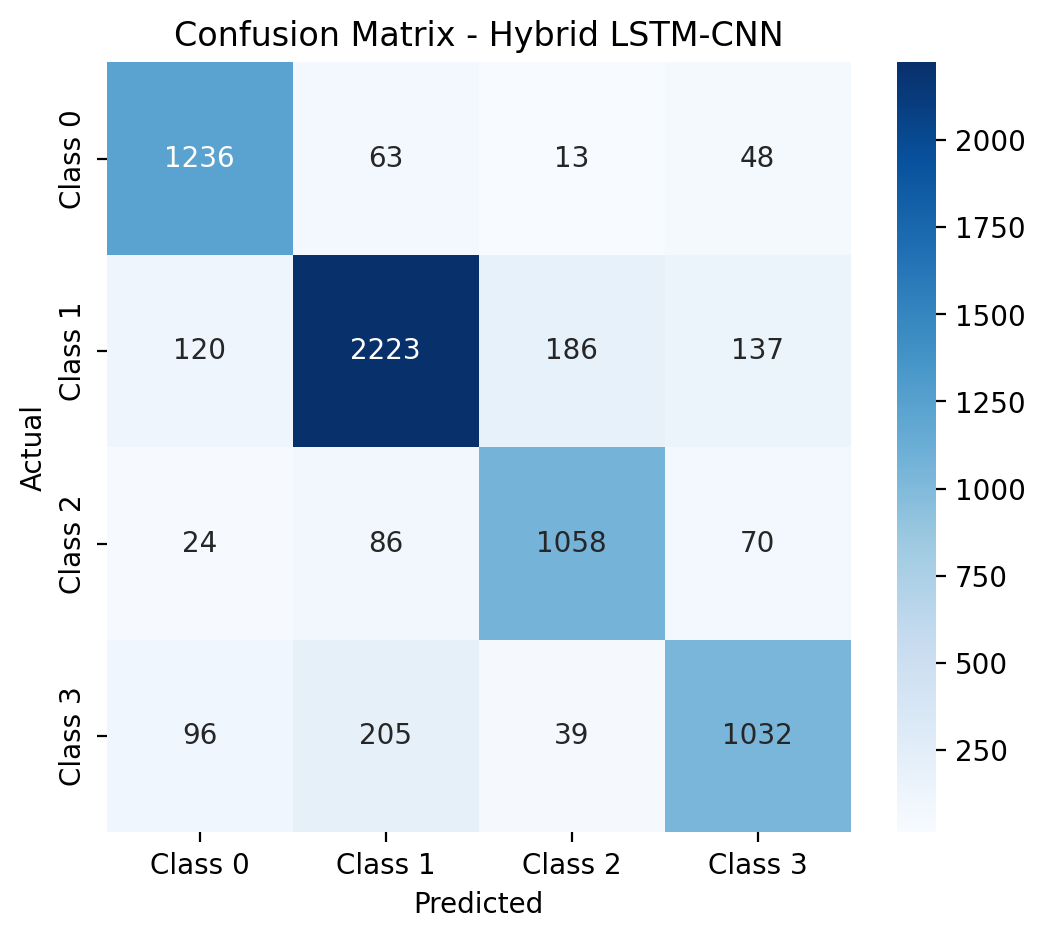


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1360
           1       0.86      0.83      0.85      2666
           2       0.82      0.85      0.84      1238
           3       0.80      0.75      0.78      1372

    accuracy                           0.84      6636
   macro avg       0.83      0.84      0.83      6636
weighted avg       0.84      0.84      0.84      6636



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.layers import Input, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ==========================
# Define callbacks
# ==========================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_hybrid_model.h5', monitor='val_loss', save_best_only=True)
]

# ==========================
# Build Hybrid LSTM-CNN model
# ==========================
print("\n" + "="*30)
print("Building Hybrid LSTM-CNN Model...")
print("="*30)

input_layer = Input(shape=input_shape)

# ----- LSTM branch -----
lstm_branch = LSTM(64, return_sequences=True)(input_layer)
lstm_branch = Dropout(0.3)(lstm_branch)
lstm_branch = LSTM(32)(lstm_branch)
lstm_branch = Dropout(0.3)(lstm_branch)

# ----- CNN branch -----
cnn_branch = Conv1D(64, kernel_size=3, activation='relu')(input_layer)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)
cnn_branch = Conv1D(32, kernel_size=3, activation='relu')(cnn_branch)
cnn_branch = MaxPooling1D(pool_size=2)(cnn_branch)
cnn_branch = Dropout(0.3)(cnn_branch)
cnn_branch = Flatten()(cnn_branch)

# ----- Combine branches -----
combined = Concatenate()([lstm_branch, cnn_branch])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.3)(combined)
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.2)(combined)
output = Dense(num_classes, activation='softmax')(combined)

# ----- Compile model -----
hybrid_model = Model(inputs=input_layer, outputs=output)
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Hybrid Model Summary:")
hybrid_model.summary()

# ==========================
# Train Hybrid model
# ==========================
print("Training Hybrid Model...")
hybrid_history = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# ==========================
# Evaluate & Confusion Matrix
# ==========================
print("\nEvaluating Hybrid Model...")
test_loss, test_acc = hybrid_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

# Predictions
y_pred_probs = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm1 = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Class {i}" for i in range(num_classes)],
            yticklabels=[f"Class {i}" for i in range(num_classes)])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid LSTM-CNN")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))



Model: LSTM
Final Training Accuracy:  0.8507
Final Validation Accuracy: 0.8062


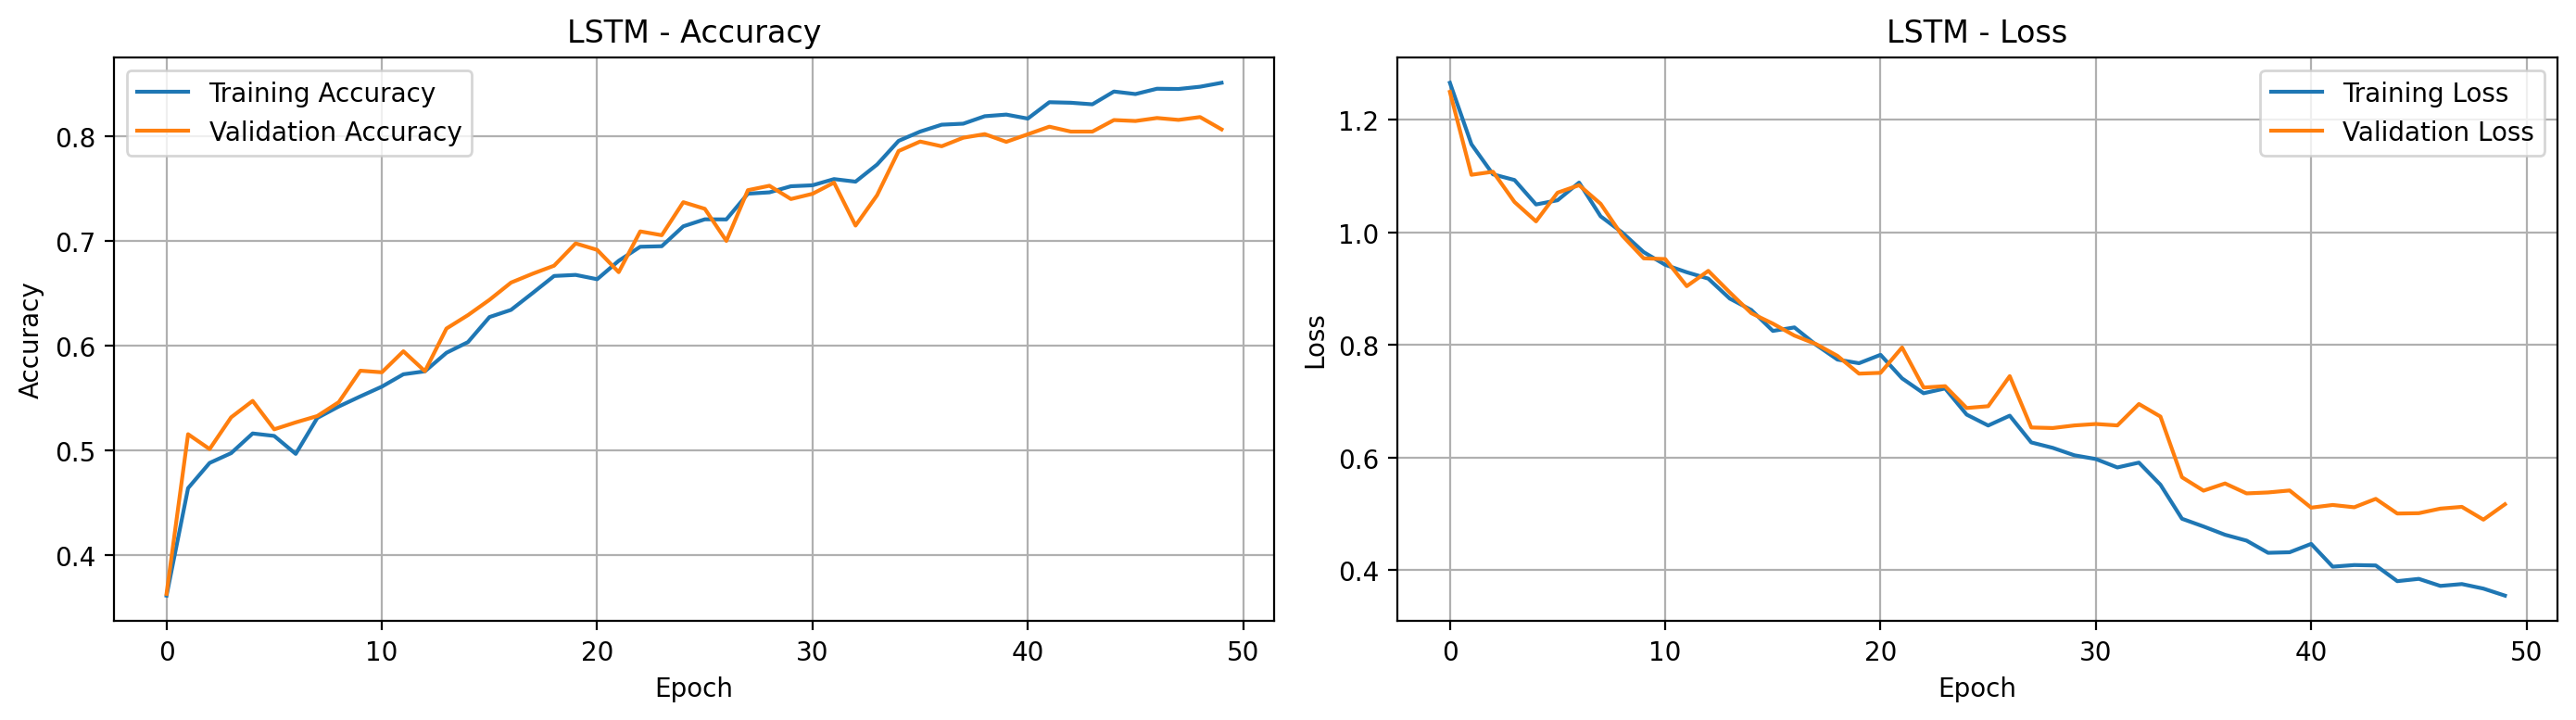


Model: CNN
Final Training Accuracy:  0.9106
Final Validation Accuracy: 0.8680


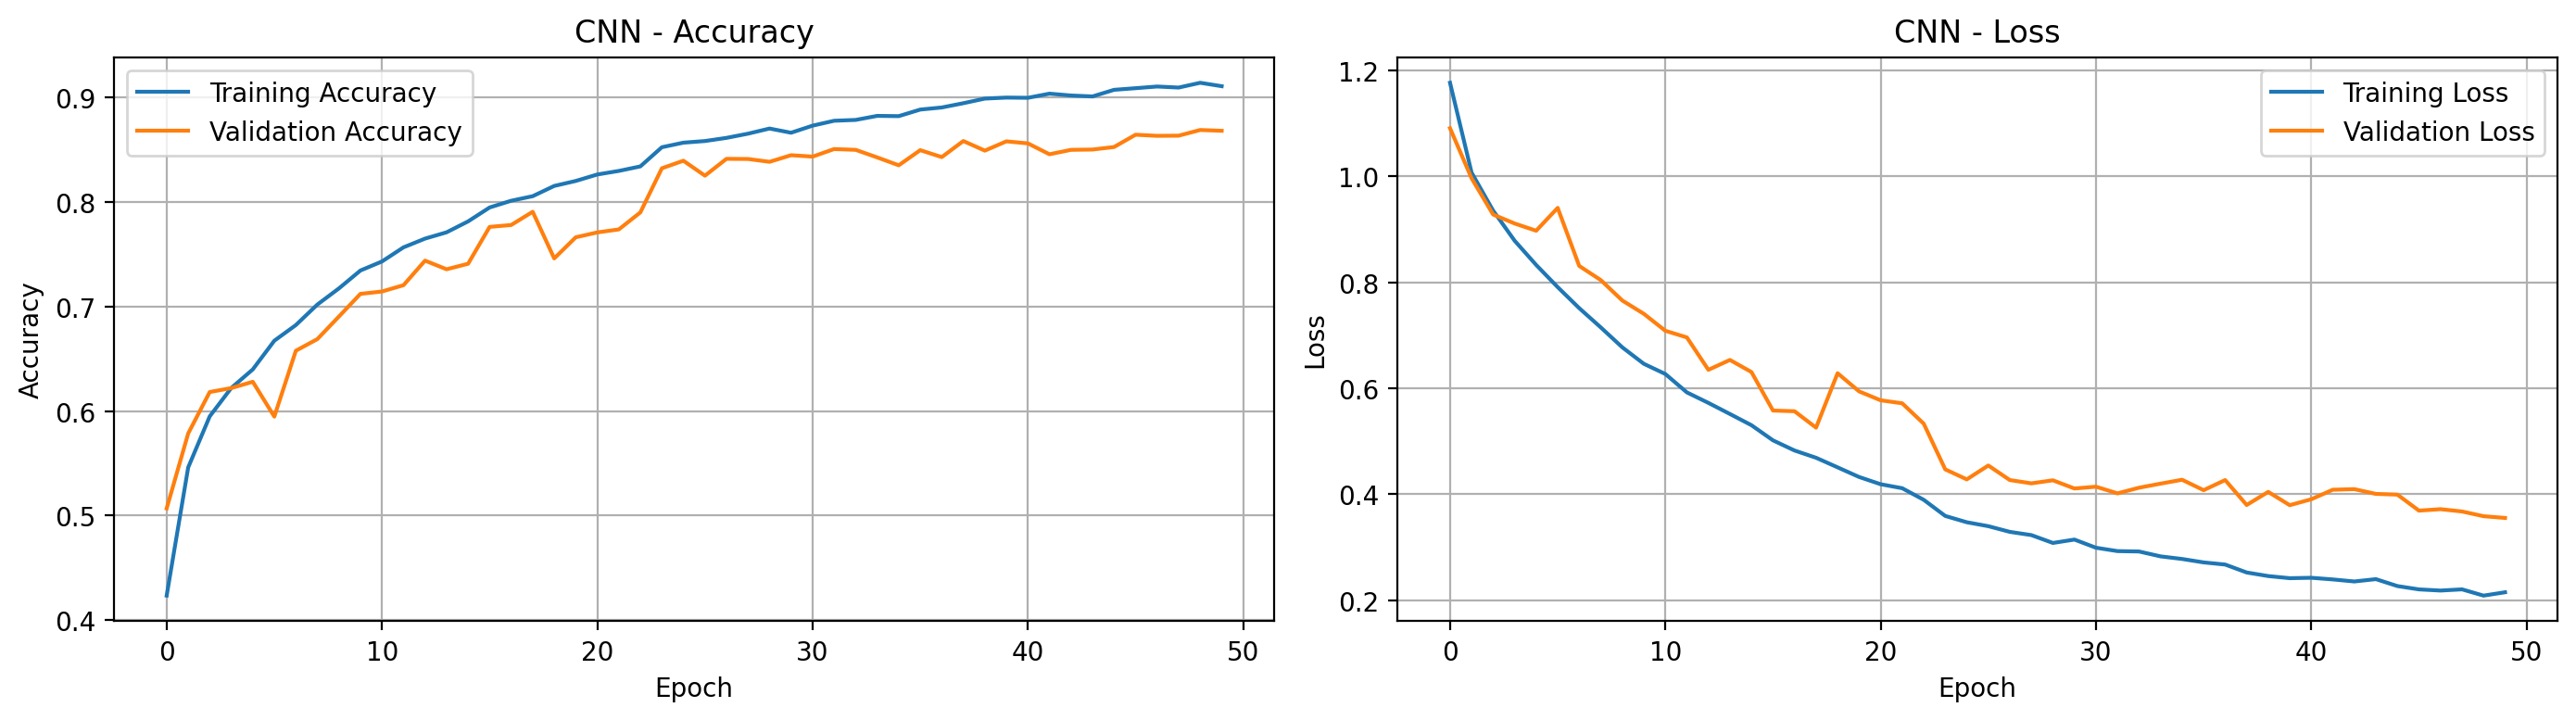


Model: CNN1
Final Training Accuracy:  0.8833
Final Validation Accuracy: 0.8927


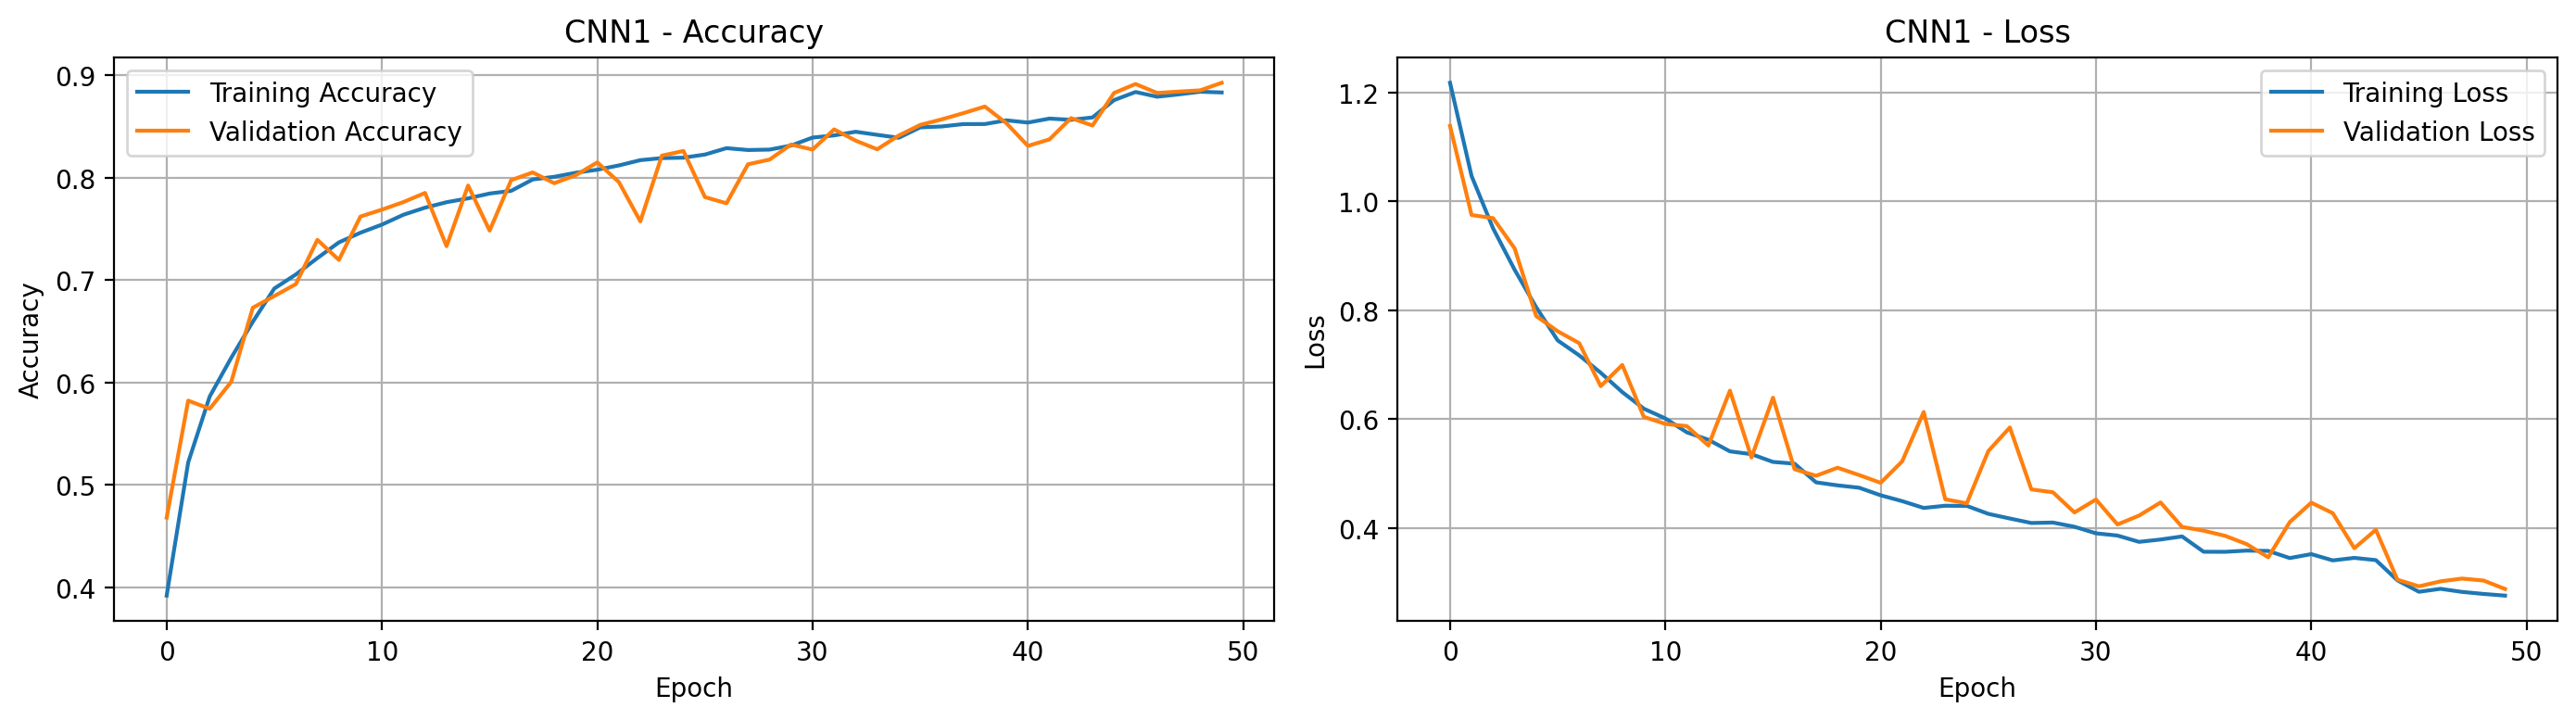


Model: LSTM-CNN
Final Training Accuracy:  0.8718
Final Validation Accuracy: 0.8445


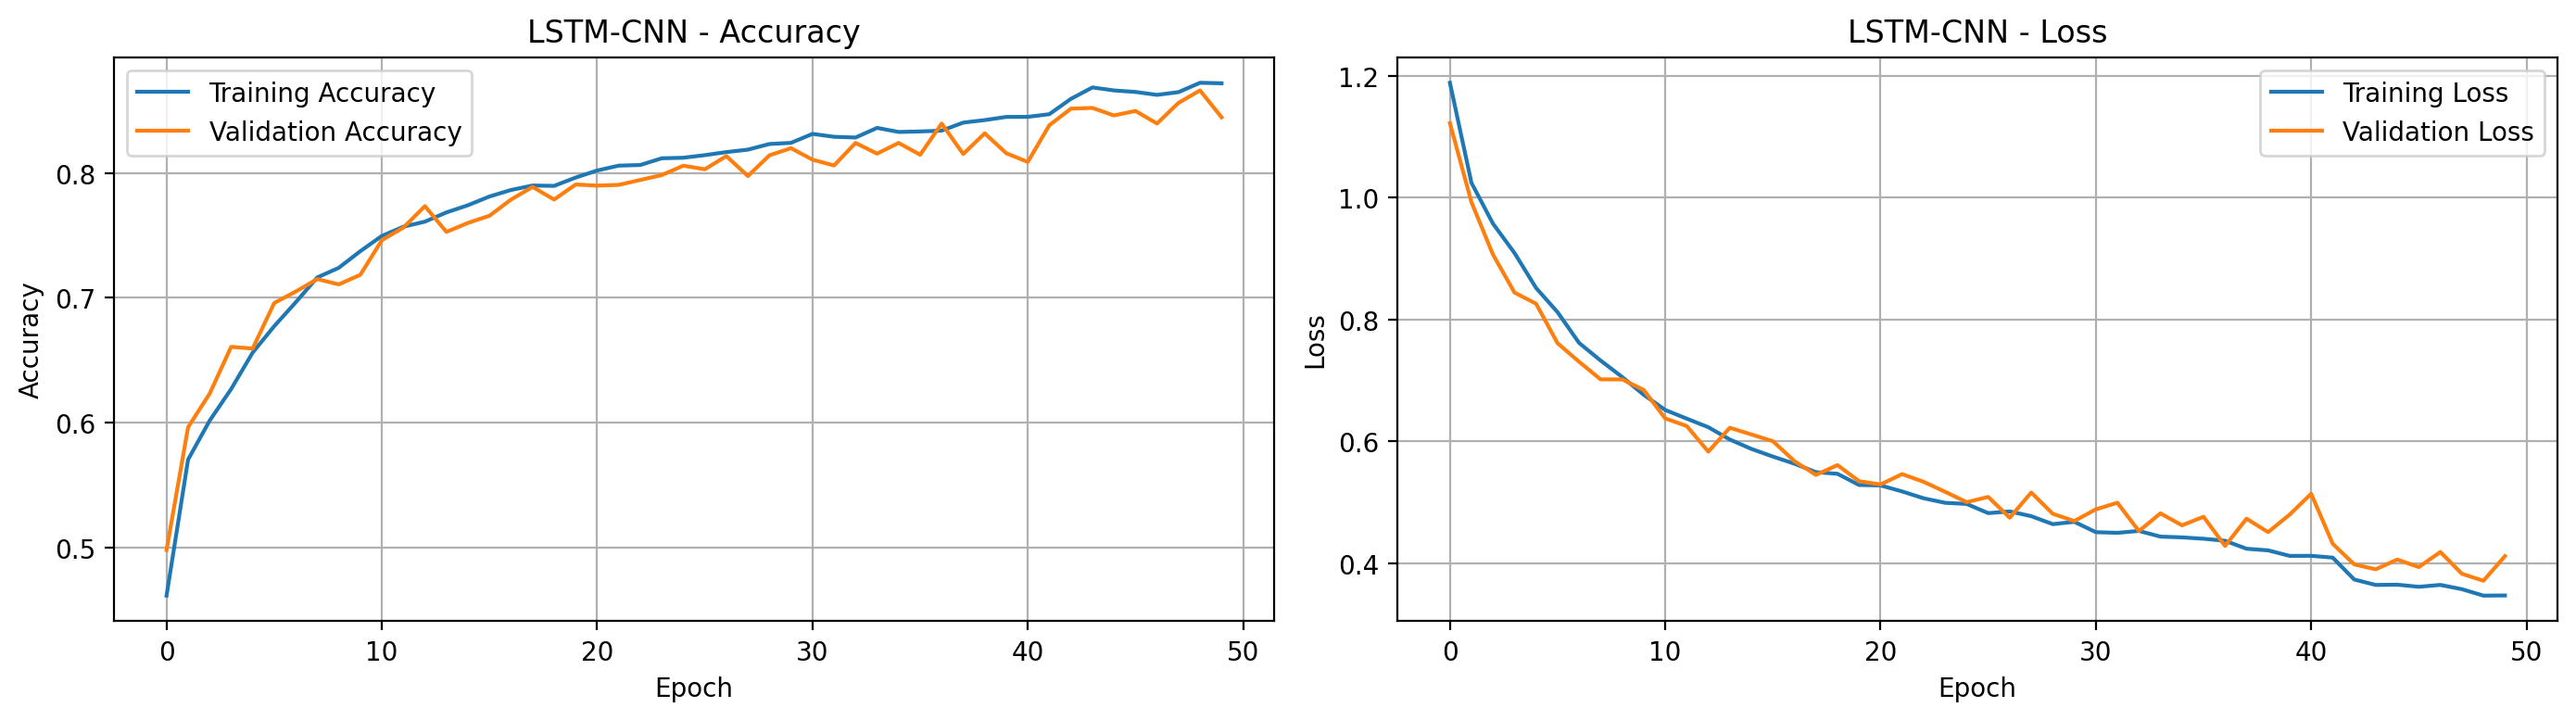

In [ ]:
import matplotlib.pyplot as plt

# Dictionary mapping model names to their history variables
model_histories = {
    'LSTM': history,
    'CNN': cnn_history,
    'CNN1': cnn_history1,
    'LSTM-CNN': hybrid_history
}

# Plot and display accuracy for each model
for model_name, hist in model_histories.items():
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(len(acc))

    # Print final accuracy
    print(f"\nModel: {model_name}")
    print(f"Final Training Accuracy:  {acc[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

    # Plot
    plt.figure(figsize=(14, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Based on the final training and validation accuracies of the four models (LSTM, CNN, CNN1, and LSTM-CNN), here's a concise and structured **conclusion**:

---

 **Model Performance Comparison Conclusion**

1. **CNN1** performed the best overall, achieving the **highest validation accuracy of 89.27%**. This indicates excellent generalization to unseen data, even slightly outperforming its training accuracy, which suggests a well-balanced model without overfitting.

2. **CNN** also performed strongly, with a **training accuracy of 91.06%** and a **validation accuracy of 86.80%**. Although it had the highest training accuracy, the slightly lower validation accuracy compared to CNN1 hints at mild overfitting.

3. **LSTM-CNN (Hybrid model)** achieved a **training accuracy of 87.18%** and a **validation accuracy of 84.45%**, showing solid performance but not surpassing the pure CNN models. This suggests that while combining LSTM and CNN helps capture both spatial and temporal patterns, in this case, the added complexity did not yield the best validation results.

4. **LSTM** had the **lowest performance**, with a **training accuracy of 85.07%** and **validation accuracy of 80.62%**. This indicates that a pure temporal sequence modeling approach may be less effective than convolution-based models for this particular dataset/task.

---

**Summary Table**

| Model        | Training Accuracy | Validation Accuracy | Notes                                  |
| ------------ | ----------------- | ------------------- | -------------------------------------- |
| **LSTM**     | 85.07%            | 80.62%              | Lowest accuracy; underperforms others  |
| **CNN**      | **91.06%**        | 86.80%              | High training accuracy; slight overfit |
| **CNN1**     | 88.33%            | **89.27%**          | Best validation performance            |
| **LSTM-CNN** | 87.18%            | 84.45%              | Balanced but not best                  |

---

 **Recommendation**

* **Use CNN1 for deployment** if the goal is **highest validation accuracy and generalization**.
* Consider tuning the **CNN and LSTM-CNN models further** (e.g., regularization, dropout, early stopping) to reduce overfitting and close the gap between training and validation accuracy.
